In [103]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from skimage.morphology import closing, square
from plot import plot_two_figures, plot_confusion_matrix, plot_each_labels, plot_histogram_compare_predict_expect
from tools import get_number_components, extract_features, remove_unclassified_input, shuffle, split_x_train_test     

# Loading data & Pre-processing

Loading Indiana and Salinas images and their ground truth

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_classes_indiana = len(np.unique(indiana_labels)) - 1
n_classes_salinas = len(np.unique(salinas_labels)) - 1

In [7]:
print("Number of labels Indiana: {}".format(n_classes_indiana))
print("Number of labels Salinas: {}".format(n_classes_salinas))

Number of labels Indiana: 16
Number of labels Salinas: 16


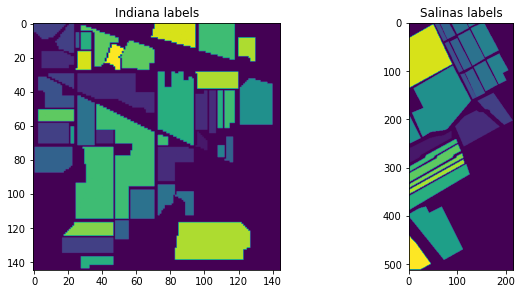

In [8]:
# Display ground truth for each image
plot_two_figures(indiana_labels, salinas_labels, title_fig1='Indiana labels', title_fig2='Salinas labels')

## Remove unclassified data

In [9]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [10]:
print(X_indiana.shape)
print(X_indiana_idx.shape)
print(X_salinas.shape)
print(X_salinas_idx.shape)

(10249, 200)
(10249,)
(54129, 204)
(54129,)


In [11]:
indiana_labels_usefull, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels_usefull, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

## PCA

PCA stands for principal component analysis. PCA is an unsupervised technique used for reduce the dimensions of the dataset. It transforms the dataset reducing the number of components in order to decrease the computational complexity of the model. 

To reduce the number of component, the PCA computes a linear transformation performing a linear mapping of the data to a lower-dimensional space. It aims to reduce the dimensions with a maximized variance of the data.

In [12]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [13]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [14]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [15]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / test

We will use a supervised learning algorithm. We need to split our dataset into training and testing dataset. To be sure that our splitting is efficient, we decided to manually split data for each label, it is not possible to use train_test_split. In addition, we decided to shuffle our data so that the split does not return us the first values of each label in the ground truth.

We are going to use 75% of the data as the training dataset and 25% for the testing.

In [16]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels_usefull)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels_usefull)

In [17]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [18]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [19]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [20]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

Cluster: 0
Nb total samples: 2009
Nb samples train: 1506
Nb samples test: 503
---------------
Cluster: 1
Nb total samples: 3726
Nb samples train: 2794
Nb samples test: 932
---------------
Cluster: 2
Nb total samples: 1976
Nb samples train: 1482
Nb samples test: 494
---------------
Cluster: 3
Nb total samples: 1394
Nb samples train: 1045
Nb samples test: 349
---------------
Cluster: 4
Nb total samples: 2678
Nb samples train: 2008
Nb samples test: 670
---------------
Cluster: 5
Nb total samples: 3959
Nb samples train: 2969
Nb samples test: 990
---------------
Cluster: 6
Nb total samples: 3579
Nb samples train: 2684
Nb samples test: 895
---------------
Cluster: 7
Nb total samples: 11271
Nb samples train: 8453
Nb samples test: 2818
---------------
Cluster: 8
Nb total samples: 6203
Nb samples train: 4652
Nb samples test: 1551
---------------
Cluster: 9
Nb total samples: 3278
Nb samples train: 2458
Nb samples test: 820
---------------
Cluster: 10
Nb total samples: 1068
Nb samples train: 801


In [21]:
print("Indiana")
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))
print("----------")
print("Indiana")
print("Train shape: {}".format(x_train_salinas.shape))
print("Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Test shape: {}".format(x_test_salinas.shape))
print("Test labels shape: {}".format(y_test_salinas_labels.shape))

Indiana
Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)
----------
Indiana
Train shape: (40592, 5)
Train labels shape: (40592,)
Test shape: (13537, 5)
Test labels shape: (13537,)


## Supervised model

TODO: explain random forest

In [39]:
modelRF_indiana = RandomForestClassifier(n_estimators=300, verbose=1, n_jobs=8)
modelRF_salinas = RandomForestClassifier(n_estimators=300, verbose=1, n_jobs=8)

In [40]:
modelRF_indiana.fit(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    6.9s finished


RandomForestClassifier(n_estimators=300, n_jobs=8, verbose=1)

In [41]:
modelRF_salinas.fit(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    9.4s finished


RandomForestClassifier(n_estimators=300, n_jobs=8, verbose=1)

In [42]:
# training score
modelRF_indiana.score(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.4s finished


1.0

In [43]:
# testintg score
modelRF_indiana.score(x_test_indiana, y_test_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished


0.8221097703386532

In [44]:
# training score
modelRF_salinas.score(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    1.6s finished


1.0

In [45]:
# test score
modelRF_salinas.score(x_test_salinas, y_test_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.5s finished


0.9414936839772475

#### Test the Indiana model on training and testing data (for each class)

In [109]:
modelRF_indiana.verbose = 0
indiana_training_score = 0
for cluster in labels_indiana:
    idxs = np.argwhere(y_train_indiana_labels == cluster).flatten()
    score = modelRF_indiana.score(x_train_indiana[idxs], y_train_indiana_labels[idxs])
    indiana_training_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
indiana_training_score /= labels_indiana.size
print("Training score: {}".format(indiana_training_score))

Cluster: 0
Nb samples: 34
Score: 1.0
-----------
Cluster: 1
Nb samples: 1071
Score: 1.0
-----------
Cluster: 2
Nb samples: 622
Score: 1.0
-----------
Cluster: 3
Nb samples: 177
Score: 1.0
-----------
Cluster: 4
Nb samples: 362
Score: 1.0
-----------
Cluster: 5
Nb samples: 547
Score: 1.0
-----------
Cluster: 6
Nb samples: 21
Score: 1.0
-----------
Cluster: 7
Nb samples: 358
Score: 1.0
-----------
Cluster: 8
Nb samples: 15
Score: 1.0
-----------
Cluster: 9
Nb samples: 729
Score: 1.0
-----------
Cluster: 10
Nb samples: 1841
Score: 1.0
-----------
Cluster: 11
Nb samples: 444
Score: 1.0
-----------
Cluster: 12
Nb samples: 153
Score: 1.0
-----------
Cluster: 13
Nb samples: 948
Score: 1.0
-----------
Cluster: 14
Nb samples: 289
Score: 1.0
-----------
Cluster: 15
Nb samples: 69
Score: 1.0
-----------
Training score: 1.0


In [110]:
indiana_testing_score = 0
for cluster in labels_indiana:
    idxs = np.argwhere(y_test_indiana_labels == cluster).flatten()
    score = modelRF_indiana.score(x_test_indiana[idxs], y_test_indiana_labels[idxs])
    indiana_testing_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
indiana_testing_score /= len(labels_indiana)
print(indiana_testing_score)

Cluster: 0
Nb samples: 12
Score: 0.4166666666666667
-----------
Cluster: 1
Nb samples: 357
Score: 0.7843137254901961
-----------
Cluster: 2
Nb samples: 208
Score: 0.6009615384615384
-----------
Cluster: 3
Nb samples: 60
Score: 0.36666666666666664
-----------
Cluster: 4
Nb samples: 121
Score: 0.8925619834710744
-----------
Cluster: 5
Nb samples: 183
Score: 0.9726775956284153
-----------
Cluster: 6
Nb samples: 7
Score: 0.42857142857142855
-----------
Cluster: 7
Nb samples: 120
Score: 1.0
-----------
Cluster: 8
Nb samples: 5
Score: 0.6
-----------
Cluster: 9
Nb samples: 243
Score: 0.7407407407407407
-----------
Cluster: 10
Nb samples: 614
Score: 0.9087947882736156
-----------
Cluster: 11
Nb samples: 149
Score: 0.6308724832214765
-----------
Cluster: 12
Nb samples: 52
Score: 1.0
-----------
Cluster: 13
Nb samples: 317
Score: 0.9873817034700315
-----------
Cluster: 14
Nb samples: 97
Score: 0.5463917525773195
-----------
Cluster: 15
Nb samples: 24
Score: 0.75
-----------
0.7266625670774481


#### Test the Salinas model on training and testing data (for each class)

In [111]:
modelRF_salinas.verbose = 0
salinas_training_score = 0
for cluster in labels_salinas:
    idxs = np.argwhere(y_train_salinas_labels == cluster).flatten()
    score = modelRF_salinas.score(x_train_salinas[idxs], y_train_salinas_labels[idxs])
    salinas_training_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_salinas_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
salinas_training_score /= labels_salinas.size
print(salinas_training_score)

Cluster: 0
Nb samples: 1506
Score: 1.0
-----------
Cluster: 1
Nb samples: 2794
Score: 1.0
-----------
Cluster: 2
Nb samples: 1482
Score: 1.0
-----------
Cluster: 3
Nb samples: 1045
Score: 1.0
-----------
Cluster: 4
Nb samples: 2008
Score: 1.0
-----------
Cluster: 5
Nb samples: 2969
Score: 1.0
-----------
Cluster: 6
Nb samples: 2684
Score: 1.0
-----------
Cluster: 7
Nb samples: 8453
Score: 1.0
-----------
Cluster: 8
Nb samples: 4652
Score: 1.0
-----------
Cluster: 9
Nb samples: 2458
Score: 1.0
-----------
Cluster: 10
Nb samples: 801
Score: 1.0
-----------
Cluster: 11
Nb samples: 1445
Score: 1.0
-----------
Cluster: 12
Nb samples: 687
Score: 1.0
-----------
Cluster: 13
Nb samples: 802
Score: 1.0
-----------
Cluster: 14
Nb samples: 5451
Score: 1.0
-----------
Cluster: 15
Nb samples: 1355
Score: 1.0
-----------
1.0


In [112]:
salinas_testing_score = 0
for cluster in labels_salinas:
    idxs = np.argwhere(y_test_salinas_labels == cluster).flatten()
    score = modelRF_salinas.score(x_test_salinas[idxs], y_test_salinas_labels[idxs])
    salinas_testing_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_salinas_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
salinas_testing_score /= len(labels_salinas)
print(salinas_testing_score)

Cluster: 0
Nb samples: 503
Score: 0.9980119284294234
-----------
Cluster: 1
Nb samples: 932
Score: 0.9957081545064378
-----------
Cluster: 2
Nb samples: 494
Score: 0.9939271255060729
-----------
Cluster: 3
Nb samples: 349
Score: 0.997134670487106
-----------
Cluster: 4
Nb samples: 670
Score: 0.9865671641791045
-----------
Cluster: 5
Nb samples: 990
Score: 1.0
-----------
Cluster: 6
Nb samples: 895
Score: 0.9988826815642458
-----------
Cluster: 7
Nb samples: 2818
Score: 0.9017033356990773
-----------
Cluster: 8
Nb samples: 1551
Score: 1.0
-----------
Cluster: 9
Nb samples: 820
Score: 0.9573170731707317
-----------
Cluster: 10
Nb samples: 267
Score: 0.9850187265917603
-----------
Cluster: 11
Nb samples: 482
Score: 1.0
-----------
Cluster: 12
Nb samples: 229
Score: 0.9956331877729258
-----------
Cluster: 13
Nb samples: 268
Score: 0.9701492537313433
-----------
Cluster: 14
Nb samples: 1817
Score: 0.7550908090258668
-----------
Cluster: 15
Nb samples: 452
Score: 0.9933628318584071
---------

#### Classification report for Indiana Model

In [51]:
%%time
preds_indiana_test = modelRF_indiana.predict(x_test_indiana)

CPU times: user 309 ms, sys: 23.2 ms, total: 332 ms
Wall time: 169 ms


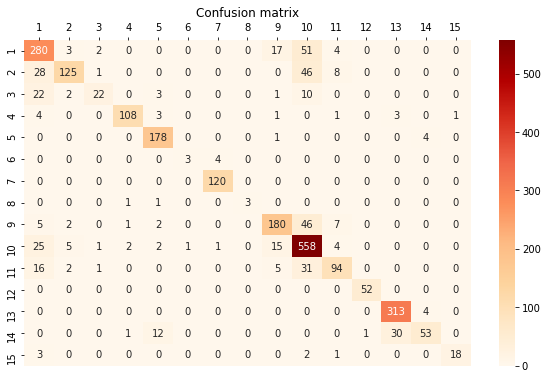

In [52]:
plot_confusion_matrix(y_test_indiana_labels, preds_indiana_test, class_names=np.arange(1, 16), log=False)

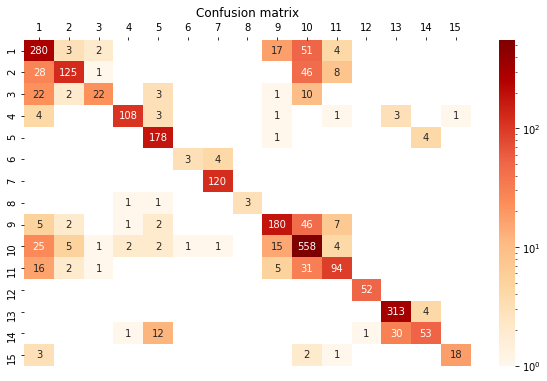

In [53]:
plot_confusion_matrix(y_test_indiana_labels, preds_indiana_test, class_names=np.arange(1, 16), log=True)

On the confusion matrix, we can see that the model performed well on all classes. There are still some misclassifications on labels 1, 2 and 3.

In [54]:
indiana_class_names = np.arange(n_classes_indiana).astype(str)

In [56]:
print(classification_report(y_test_indiana_labels, preds_indiana_test, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       1.00      0.42      0.59        12
           1       0.73      0.78      0.76       357
           2       0.90      0.60      0.72       208
           3       0.81      0.37      0.51        60
           4       0.96      0.89      0.92       121
           5       0.89      0.97      0.93       183
           6       0.75      0.43      0.55         7
           7       0.92      1.00      0.96       120
           8       1.00      0.60      0.75         5
           9       0.82      0.74      0.78       243
          10       0.75      0.91      0.82       614
          11       0.78      0.63      0.70       149
          12       0.98      1.00      0.99        52
          13       0.90      0.99      0.94       317
          14       0.87      0.55      0.67        97
          15       0.95      0.75      0.84        24

    accuracy                           0.82      2569
   macro avg       0.88   

F1-score stands for:
\begin{equation}
    \frac{TP}{TP + 0.5 * (FP + FN))}
\end{equation}
    
Recall stands for:

\begin{equation}
    \frac{TP}{TP + FN}
\end{equation}

So here we can see that class 0, has been correctly detected (1.0 accuracy) but there are a low f1-score and recall. This means that there are a huge number of False Negatives

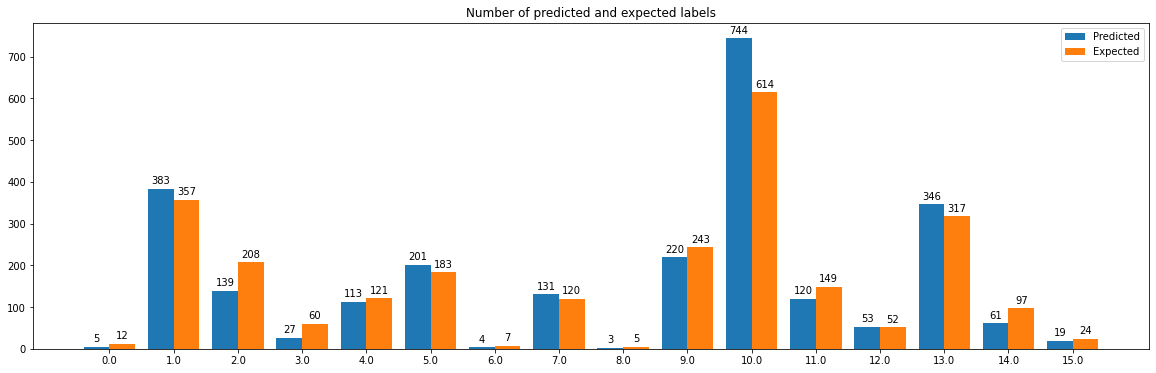

In [62]:
plot_histogram_compare_predict_expect(preds_indiana_test, y_test_indiana_labels)

#### Classification report for Salinas Model

In [57]:
preds_salinas_test = modelRF_salinas.predict(x_test_salinas)

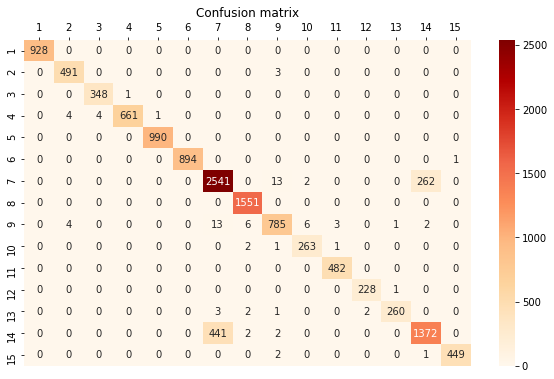

In [58]:
plot_confusion_matrix(y_test_salinas_labels, preds_salinas_test, class_names=np.arange(1, 16), log=False)

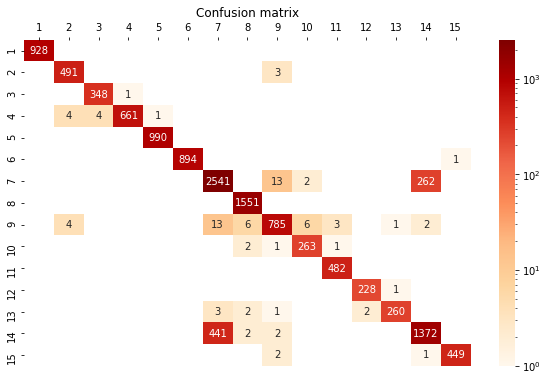

In [59]:
plot_confusion_matrix(y_test_salinas_labels, preds_salinas_test, class_names=np.arange(1, 16), log=True)

On the confusion matrix we can see that the classification on test data is quite good.

In [64]:
salinas_class_names = np.arange(n_classes_salinas).astype(str)
print(classification_report(y_test_salinas_labels, preds_salinas_test, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       503
           1       1.00      1.00      1.00       932
           2       0.98      0.99      0.99       494
           3       0.99      1.00      0.99       349
           4       1.00      0.99      0.99       670
           5       1.00      1.00      1.00       990
           6       1.00      1.00      1.00       895
           7       0.85      0.90      0.87      2818
           8       0.99      1.00      1.00      1551
           9       0.97      0.96      0.96       820
          10       0.97      0.99      0.98       267
          11       0.99      1.00      1.00       482
          12       0.99      1.00      0.99       229
          13       0.99      0.97      0.98       268
          14       0.84      0.76      0.79      1817
          15       1.00      0.99      1.00       452

    accuracy                           0.94     13537
   macro avg       0.97   

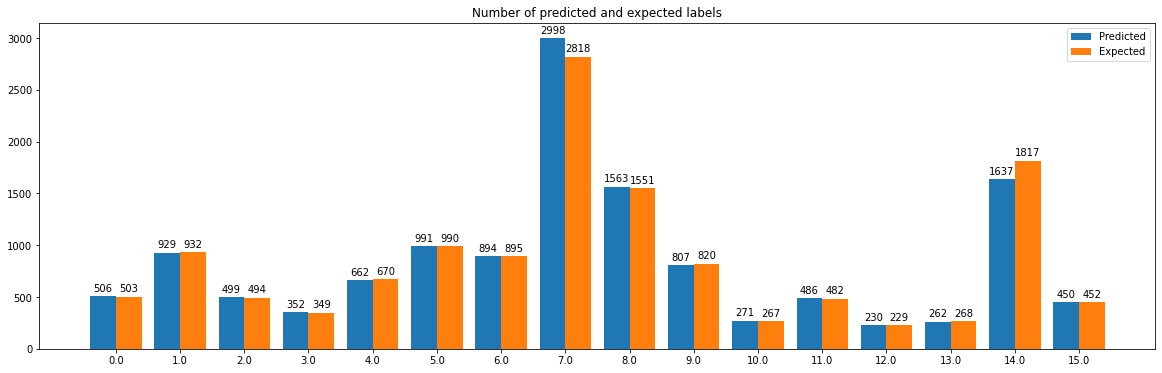

In [63]:
plot_histogram_compare_predict_expect(preds_salinas_test, y_test_salinas_labels)

In [65]:
print(classification_report(preds_salinas_test, y_test_salinas_labels, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       506
           1       1.00      1.00      1.00       929
           2       0.99      0.98      0.99       499
           3       1.00      0.99      0.99       352
           4       0.99      1.00      0.99       662
           5       1.00      1.00      1.00       991
           6       1.00      1.00      1.00       894
           7       0.90      0.85      0.87      2998
           8       1.00      0.99      1.00      1563
           9       0.96      0.97      0.96       807
          10       0.99      0.97      0.98       271
          11       1.00      0.99      1.00       486
          12       1.00      0.99      0.99       230
          13       0.97      0.99      0.98       262
          14       0.76      0.84      0.79      1637
          15       0.99      1.00      1.00       450

    accuracy                           0.94     13537
   macro avg       0.97   

### Prediction on images

#### Indiana image

In [66]:
total_preds_indiana = modelRF_indiana.predict(X_indiana_reduced)

In [67]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_preds_img[X_indiana_idx] = total_preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape(((indiana_img.shape[0], indiana_img.shape[1])))

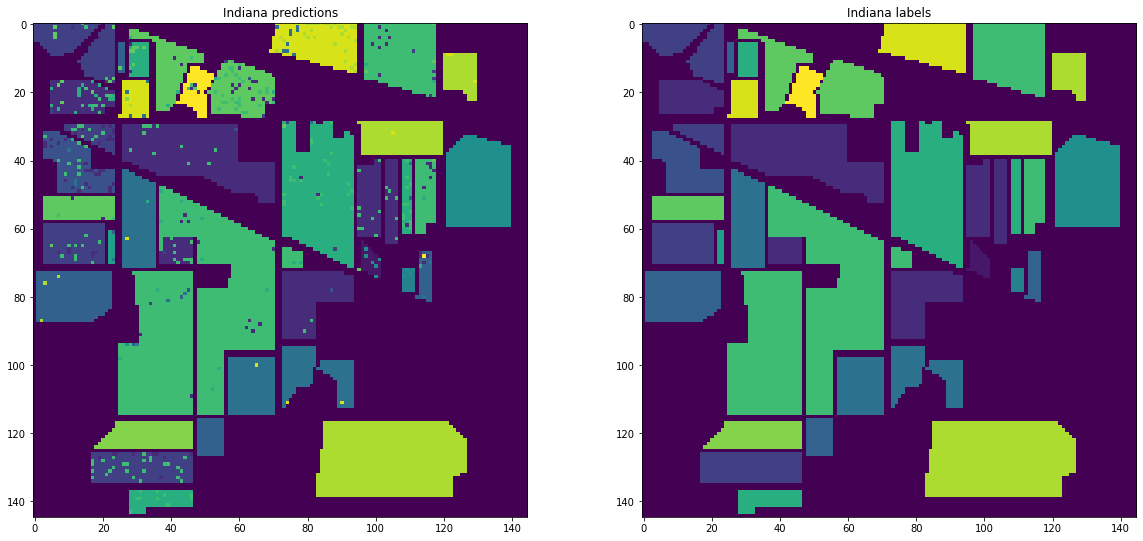

In [68]:
plot_two_figures(indiana_preds_img, indiana_labels, 'Indiana predictions', 'Indiana labels', figsize=(20, 20))

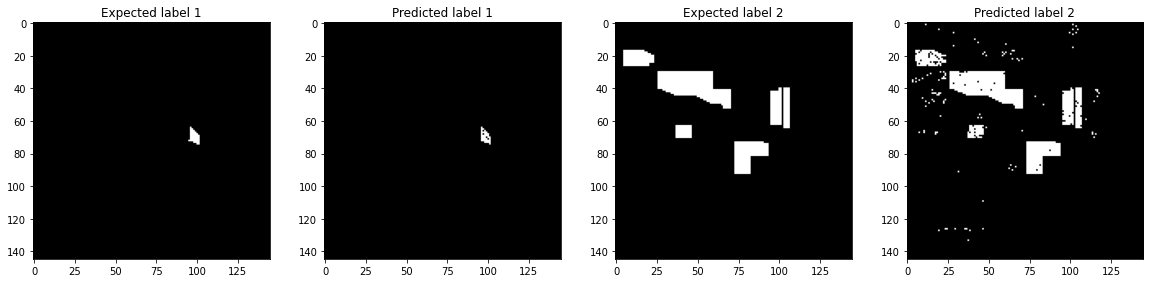

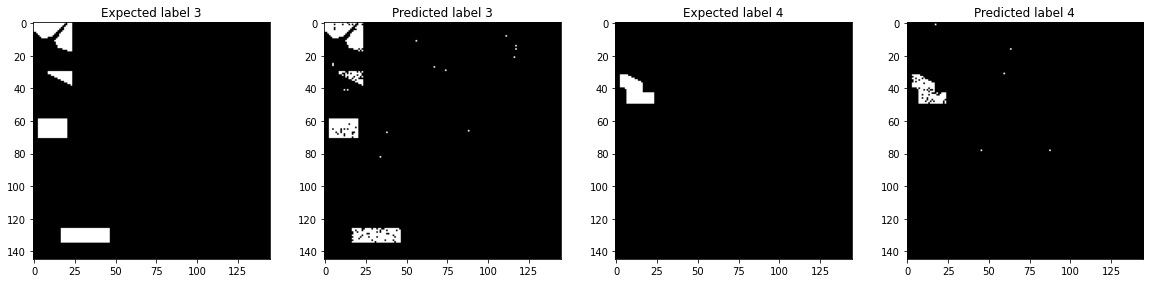

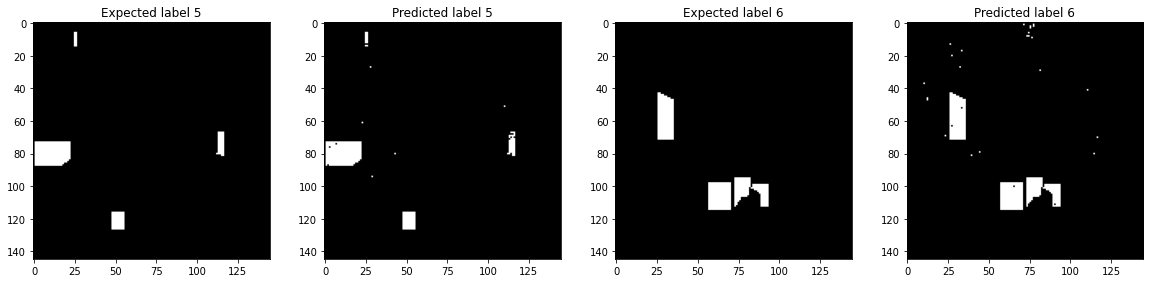

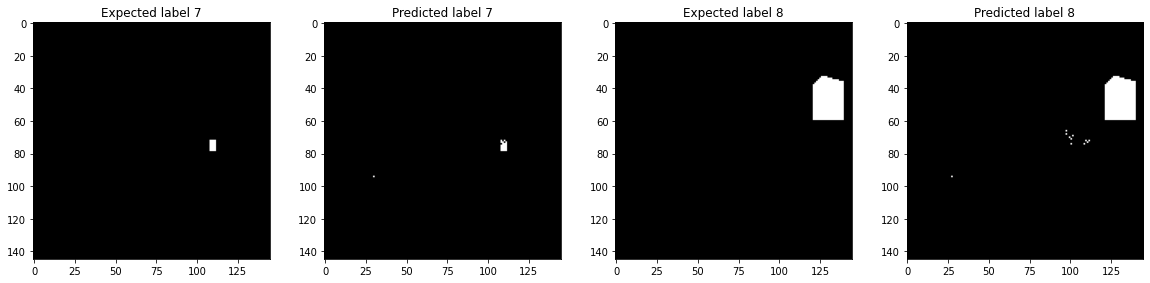

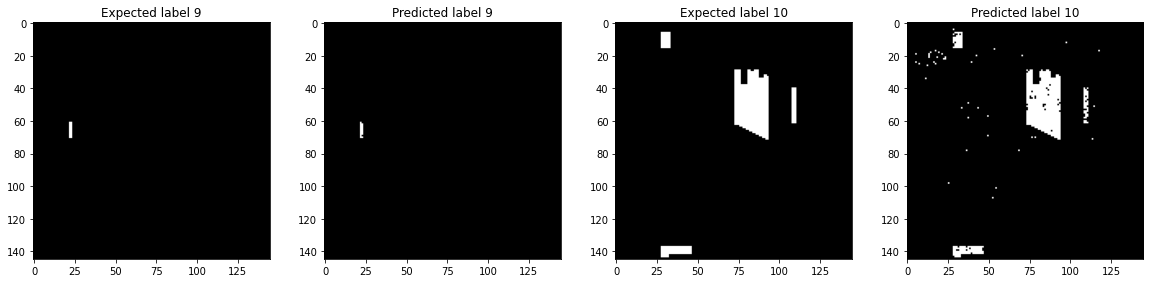

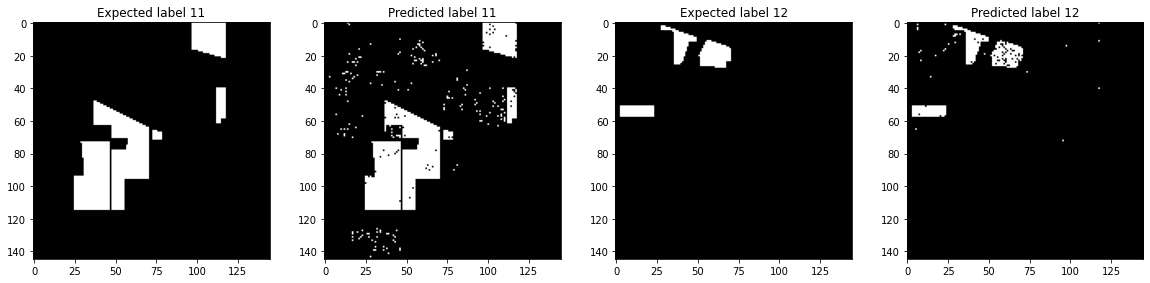

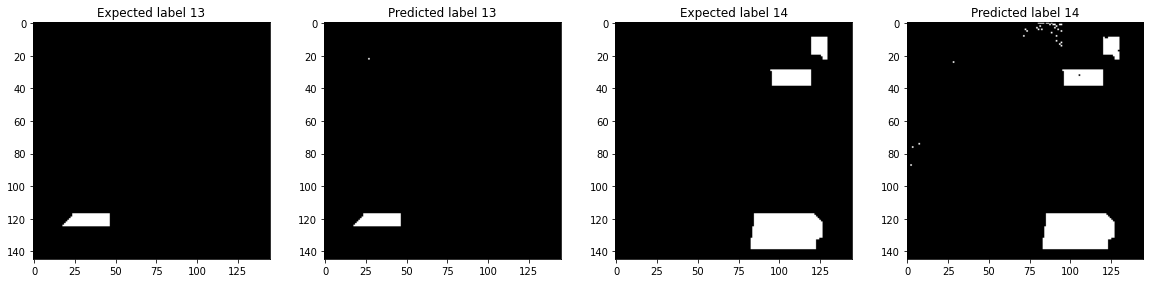

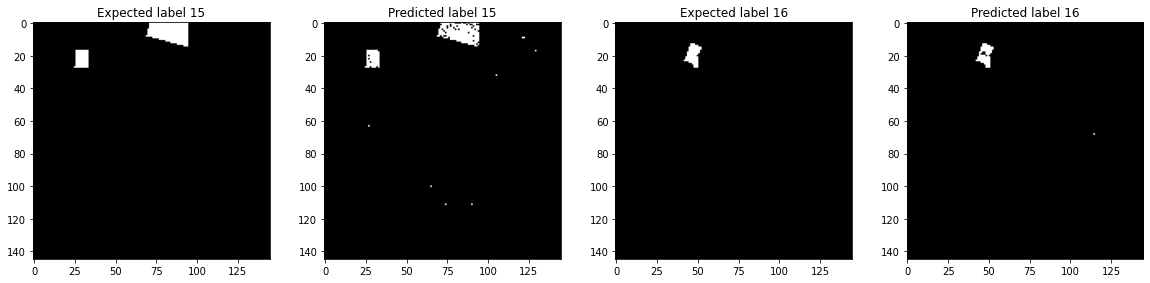

In [92]:
plot_each_labels(indiana_labels, indiana_preds_img, n_classes_indiana, figsize=(20, 20), cmap='gray')

#### Salinas image

In [93]:
total_preds_salinas = modelRF_salinas.predict(X_salinas_reduced)

In [94]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_preds_img[X_salinas_idx] = total_preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape(((salinas_img.shape[0], salinas_img.shape[1])))

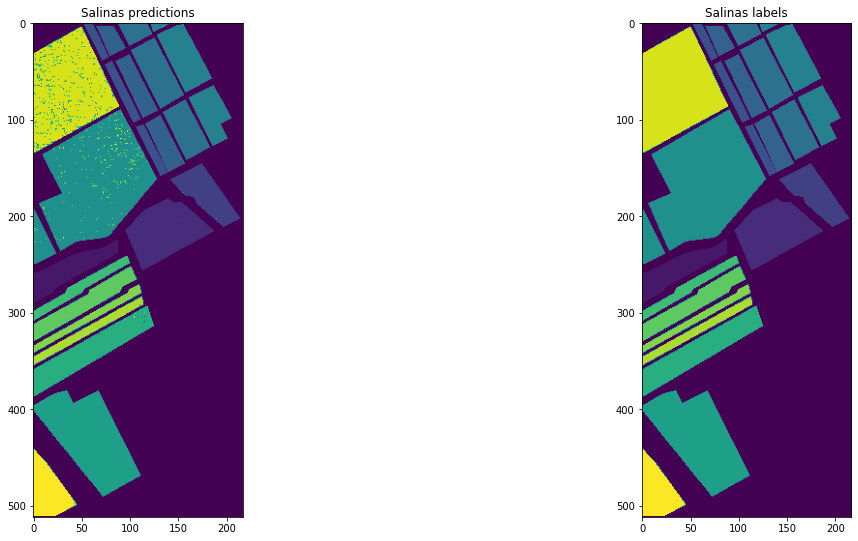

In [99]:
plot_two_figures(salinas_preds_img, salinas_labels, 'Salinas predictions', 'Salinas labels', figsize=(20, 20))

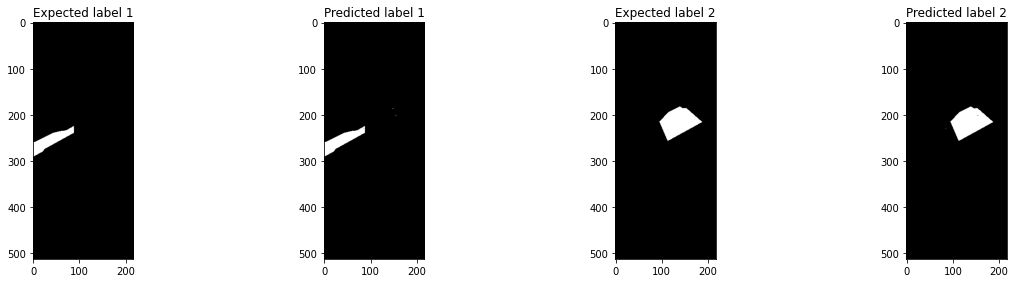

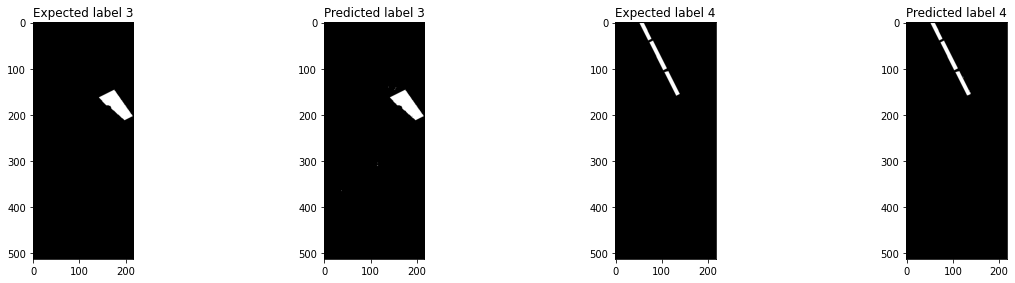

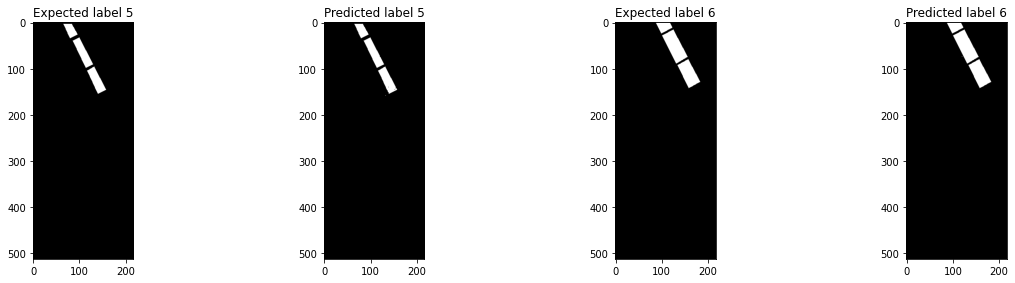

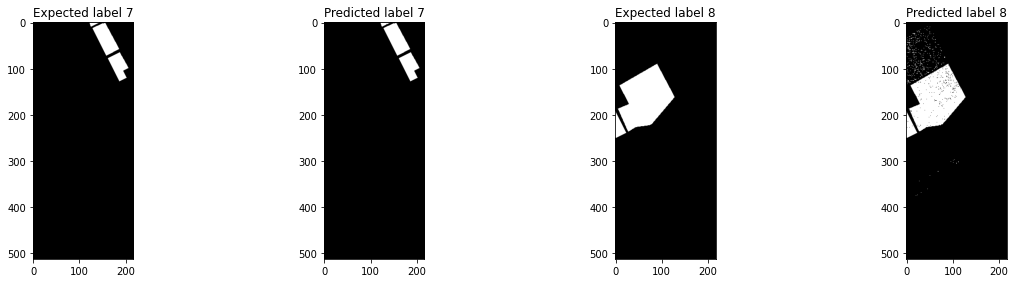

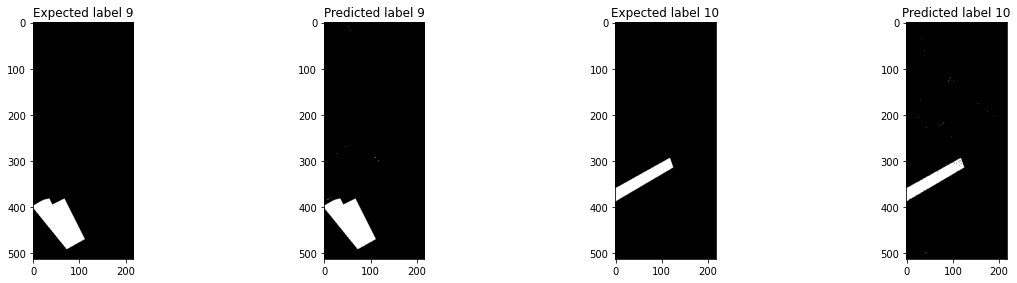

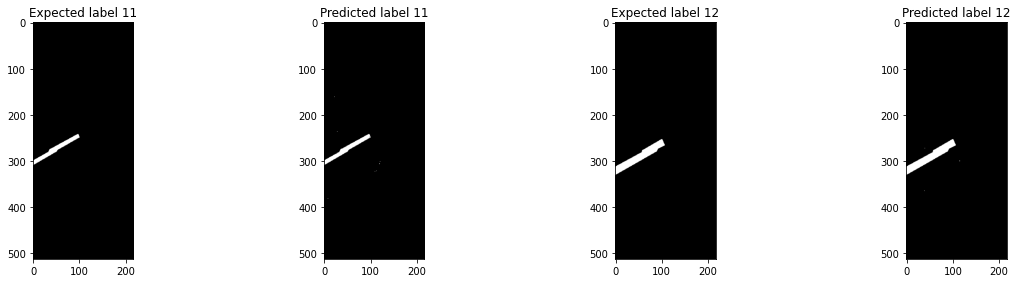

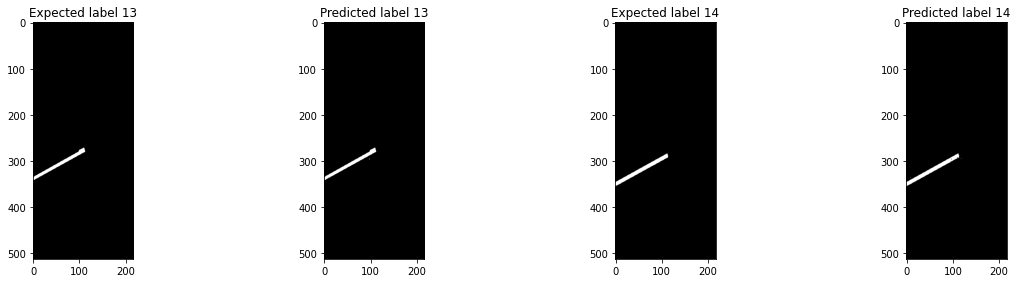

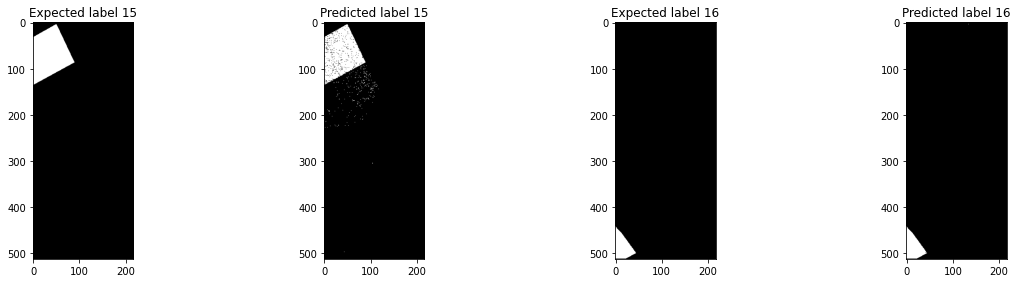

In [100]:
plot_each_labels(salinas_labels, salinas_preds_img, n_classes_salinas, figsize=(20, 20), cmap='gray')

## Save predictions

In [101]:
np.save('../data/predictions/indiana_preds_randomForest.npy', indiana_preds_img)
np.save('../data/predictions/salinas_preds_randomForest.npy', salinas_preds_img)

In [115]:
# Check if csv file exists
try:
    df = pd.read_csv('../data/score.csv')
except Exception:
    cols = ['model', 'image', 'score_test', 'score_train']
    df = pd.DataFrame(columns=cols)

In [116]:
df

,model,image,score_test,score_train
0,OneVsOneClassifier - LinearSVC,indiana,0.681977,0.704297
1,OneVsOneClassifier - LinearSVC,salinas,0.877816,0.881036
2,GaussianNaiveBayes,indiana,0.537038,0.528582
3,GaussianNaiveBayes,salinas,0.805780,0.803630


In [117]:
df.loc[df.size] = ['RandomForest', 'indiana', indiana_testing_score, indiana_training_score]
df.loc[df.size] = ['RandomForest', 'salinas', salinas_testing_score, salinas_training_score]

In [118]:
df

,model,image,score_test,score_train
0,OneVsOneClassifier - LinearSVC,indiana,0.681977,0.704297
1,OneVsOneClassifier - LinearSVC,salinas,0.877816,0.881036
2,GaussianNaiveBayes,indiana,0.537038,0.528582
3,GaussianNaiveBayes,salinas,0.805780,0.803630
16,RandomForest,indiana,0.726663,1.000000
20,RandomForest,salinas,0.970532,1.000000


In [119]:
df.to_csv('../data/score.csv', index=False)